In [ ]:
!pip install tensorflow

Processing images class: 0
Processing images class: 1
Processing images class: 2
[0 1 1 2 2 0 2 1 2 1 1 2 1 1 0 0 2 0 0 2]
{1: 300, 2: 300, 0: 300}
{0: 700, 1: 700, 2: 700}
(112, 112, 3) [0.03137254901960784, 0.03137254901960784, 0.03137254901960784, 0.058823529411764705, 0.058823529411764705, 0.058823529411764705, 0.07058823529411765, 0.07058823529411765, 0.07058823529411765, 0.08627450980392157, 0.08627450980392157, 0.08627450980392157, 0.09803921568627451, 0.09803921568627451, 0.09803921568627451, 0.12941176470588237, 0.12941176470588237, 0.12941176470588237, 0.13333333333333333, 0.13333333333333333]


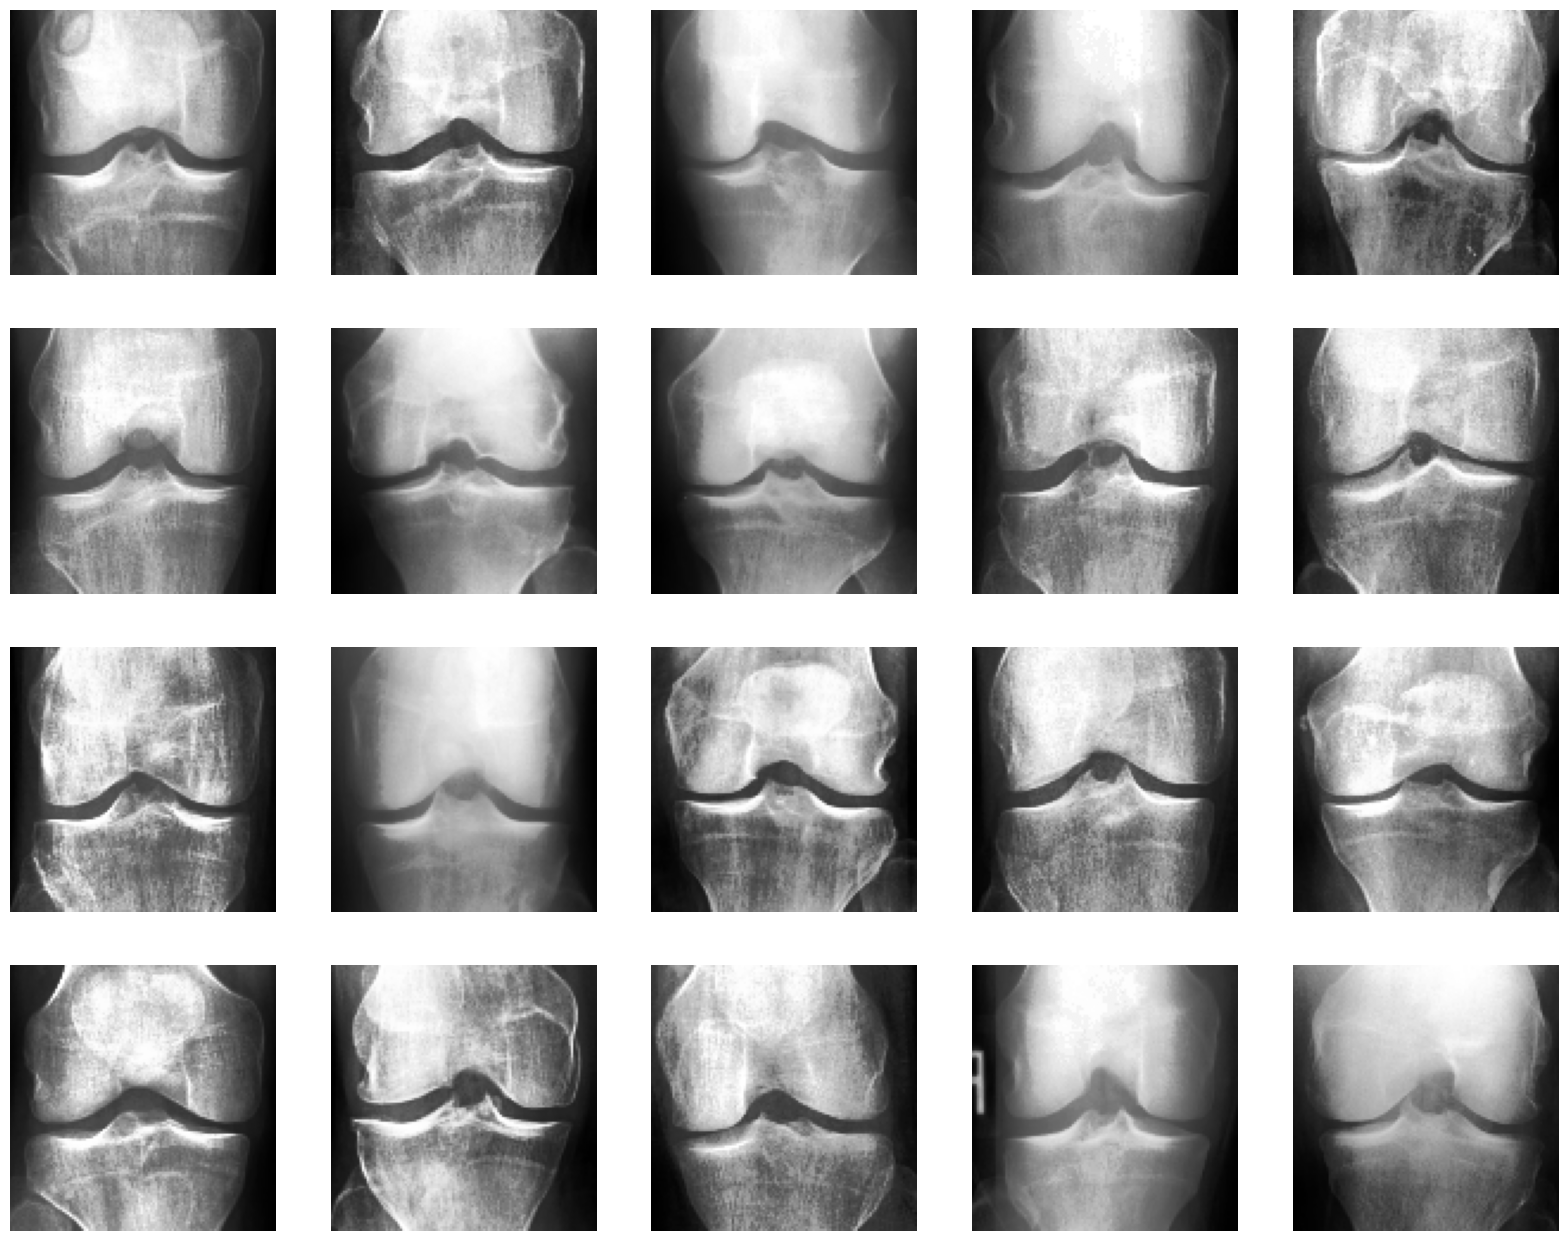

load weights? 


Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_356 (Conv2D)         (None, 112, 112, 512)     2048      
                                                                 
 max_pooling2d_22 (MaxPooli  (None, 56, 56, 512)       0         
 ng2D)                                                           
                                                                 
 leaky_re_lu_444 (LeakyReLU  (None, 56, 56, 512)       0         
 )                                                               
                                                                 
 conv2d_357 (Conv2D)         (None, 56, 56, 256)       131328    
                                                                 
 leaky_re_lu_445 (LeakyReLU  (None, 56, 56, 256)       0         
 )                                                               
                                                     

2024-02-18 18:52:29.487368: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_19/big_residual_64/dropout_147/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


66/66 [==============================] - 20s 208ms/step - loss: 1.2144 - accuracy: 0.3471 - val_loss: 1.0985 - val_accuracy: 0.3333
Epoch 2/200
66/66 [==============================] - 13s 197ms/step - loss: 1.1677 - accuracy: 0.3419 - val_loss: 1.0987 - val_accuracy: 0.3333
Epoch 3/200
66/66 [==============================] - 13s 196ms/step - loss: 1.1408 - accuracy: 0.3310 - val_loss: 1.0987 - val_accuracy: 0.3333
Epoch 4/200
66/66 [==============================] - 13s 197ms/step - loss: 1.1336 - accuracy: 0.3281 - val_loss: 1.0988 - val_accuracy: 0.3222
Epoch 5/200
66/66 [==============================] - 13s 197ms/step - loss: 1.1255 - accuracy: 0.3424 - val_loss: 1.0994 - val_accuracy: 0.3144
Epoch 6/200
66/66 [==============================] - 13s 197ms/step - loss: 1.1290 - accuracy: 0.3457 - val_loss: 1.1000 - val_accuracy: 0.3267
Epoch 7/200
66/66 [==============================] - 13s 197ms/step - loss: 1.1209 - accuracy: 0.3519 - val_loss: 1.0994 - val_accuracy: 0.3289
Epoc

In [ ]:
PATH = '/kaggle/input/kneeoa/'
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Add, GlobalAveragePooling2D, Reshape, DepthwiseConv2D, BatchNormalization, LeakyReLU

from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Layer
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.utils import plot_model, model_to_dot
from tensorflow.keras.optimizers import Adam
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import cv2, os, collections
import matplotlib.pyplot as plt


LEAKY_MULTIPLYER = 0.05
xdata = collections.defaultdict(list)

for classes in [0,1,2]:
    ls =  os.listdir(PATH+"train/"+str(classes))
    print(f"Processing images class: {classes}")
    for i, samples in enumerate(ls[:1000]):

        img = cv2.resize(cv2.imread(PATH+"train/"+str(classes)+'/'+samples),(112,112), interpolation = cv2.INTER_AREA)


        # convert from RGB color-space to YCrCb
        ycrcb_img = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)

        # equalize the histogram of the Y channel
        ycrcb_img[:, :, 0] = cv2.equalizeHist(ycrcb_img[:, :, 0])

        # convert back to RGB color-space from YCrCb
        equalized_img = cv2.cvtColor(ycrcb_img, cv2.COLOR_YCrCb2BGR)
    
        xdata[classes].append(equalized_img/255)


def show_image_samples(gen ):
    plt.figure(figsize=(20, 20))
    for i in range(len(gen)):
        plt.subplot(5, 5, i + 1)
        image=gen[i]
        plt.imshow(image)

        plt.title('', color='blue', fontsize=14)
        plt.axis('off')
    plt.show()



"""concatenating all classes and their respective labels"""
from sklearn.model_selection import train_test_split

Y = [0 for i in range(len(xdata[0]))] + [1 for i in range(len(xdata[1]))] + [2 for i in range(len(xdata[2]))] #concatenating both y data
X = xdata[0] + xdata[1] + xdata[2] #concatenating both x data

len(X), len(Y)
#sane length means correct processing

X = np.array(X)
Y = np.array(Y)

X.shape, Y.shape


xtrain, xtest, ytrain, ytest = train_test_split(X, Y, test_size=0.3, random_state=0, stratify=[0]*1000+[1]*1000+[2]*1000)
print(ytrain.ravel()[:20])
print({i:ytest.tolist().count(i) for i in ytest.tolist()})
print({i:ytrain.tolist().count(i) for i in ytrain.tolist()})
print(xtrain[0].shape,xtrain[0].ravel()[:20].tolist())
show_image_samples(xtrain[:20])

del(X)
del(Y)
del(xdata)

class BigResidual(Layer):
    def __init__(self, channels_in,kernel,**kwargs):
        super(BigResidual, self).__init__(**kwargs)
        self.channels_in = channels_in
        self.kernel = kernel
        self.depconv = DepthwiseConv2D(self.channels_in,self.kernel,padding="same")
        self.gap = GlobalAveragePooling2D()
        self.reshape = Reshape((1,1, self.channels_in))
        self.layer1=Conv2D( self.channels_in,self.kernel,padding="same")
        self.leak1=LeakyReLU(alpha=LEAKY_MULTIPLYER)
        self.layer2=Conv2D( self.channels_in,self.kernel,padding="same")
        self.leak2=LeakyReLU(alpha=LEAKY_MULTIPLYER)
        self.layer3=Conv2D( self.channels_in,self.kernel,padding="same")
        self.leak3=LeakyReLU(alpha=LEAKY_MULTIPLYER)
        self.layer4=Conv2D( self.channels_in,self.kernel,padding="same")
        self.leak4=LeakyReLU(alpha=LEAKY_MULTIPLYER)
        self.layer5=Add()
        self.layer6=LeakyReLU(alpha=LEAKY_MULTIPLYER)
        self.drop=Dropout(0.4)
        self.bn=BatchNormalization()

    def call(self, x):
        # the residual block using Keras functional API'
        first_layer = self.layer1(x)
        first_conv = self.leak2(self.layer2(first_layer))
        second_conv = self.leak3(self.layer3(first_conv))
        x = self.leak1(self.layer4(second_conv))
        residual = self.bn(self.layer5([x, first_layer, first_conv, second_conv]))
        x = self.drop(self.layer6(residual))
        return x

    def compute_output_shape(self, input_shape):
        return input_shape

model = Sequential()
model.add(Conv2D(512, (1, 1), input_shape=(112, 112, 3)))
model.add(MaxPooling2D(2,2))
model.add(LeakyReLU(alpha=LEAKY_MULTIPLYER))

model.add(Conv2D(256, (1, 1)))
model.add(LeakyReLU(alpha=LEAKY_MULTIPLYER))
model.add(BigResidual(256, (3,3)))
model.add(MaxPooling2D(3,3))

model.add(Conv2D(64, (1, 1)))
model.add(LeakyReLU(alpha=LEAKY_MULTIPLYER))
model.add(BigResidual(64, (3,3)))

model.add(Conv2D(32, (1, 1)))
model.add(LeakyReLU(alpha=LEAKY_MULTIPLYER))
model.add(BigResidual(32, (3,3)))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(64))
model.add(LeakyReLU(alpha=LEAKY_MULTIPLYER))

model.add(Dropout(0.1))
model.add(Dense(40))
model.add(LeakyReLU(alpha=LEAKY_MULTIPLYER))

model.add(Dropout(0.1))
model.add(Dense(30))
model.add(LeakyReLU(alpha=LEAKY_MULTIPLYER))

model.add(Dropout(0.1))
model.add(Dense(20))
model.add(LeakyReLU(alpha=LEAKY_MULTIPLYER))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))


model.compile(loss='sparse_categorical_crossentropy',
              optimizer=Adam(1e-05),
              metrics=['accuracy'])
saving_weights=input('load weights?')
if saving_weights == 'yes.':
    wsp=input('which?')
    model.load_weights(wsp)

model.build((None, 112, 112, 3))
print(model.summary())
plot_model(model,  show_shapes=True, show_layer_names=True, expand_nested=True, show_layer_activations=True, show_trainable=True)

batch_size = 64

# this is the augmentation configuration we will use for training
h = model.fit(xtrain, ytrain, epochs=200,batch_size=32 #64
          ,validation_data = (xtest,ytest), shuffle=True)



history = h
plt.plot(history.history['accuracy'])
# plotRegr(history, 'accuracy', plt)
plt.plot(history.history['val_accuracy'])
# plotRegr(history, 'val_accuracy', plt)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train',  'val', 'rt', 'rv'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])



# plotRegr(history, 'loss', plt)
plt.plot(history.history['val_loss'])
# plotRegr(history, 'val_loss', plt)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val', 'r', 'r'], loc='upper left')
plt.show()

# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data




model.save_weights(f'{input("enter weights name")}.h5')  # always save your weights after training or during training

Y_pred = model.predict(xtest)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(ytest, y_pred))
print('Classification Report')
target_names = ['h', 'd', 'dd']
print(classification_report(ytest, y_pred, target_names=target_names))